# Scenario 3
For scenario 3, from the description: "Explore the space of closely related models (structurally speaking) that incorporate either deaths, hospitalizations, or both.". For this purpose, models 958 and 960 are relevant.

In [14]:
from mira.modeling import Model
from mira.modeling.petri import PetriNetModel
from mira.sources.biomodels import get_template_model
from mira.metamodel import TemplateModelDelta
from mira.dkg.web_client import is_ontological_child_web

In [ ]:
# Get models 958 and 960
model_958 = get_template_model("BIOMD0000000958")
model_960 = get_template_model("BIOMD0000000960")

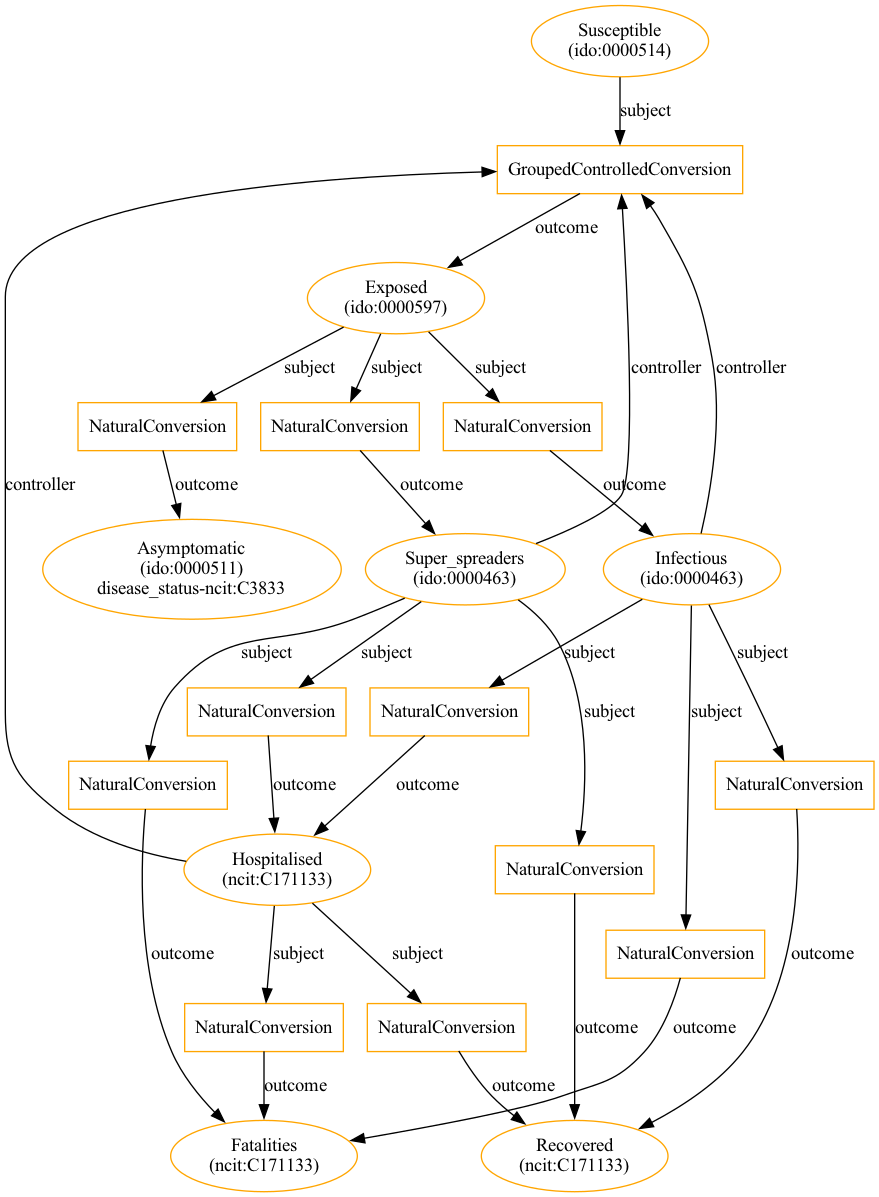

In [6]:
# Check out the models
from IPython.display import Image
model_958.draw_graph("sc3_model_958.png")
Image(filename="sc3_model_958.png", width='50%')

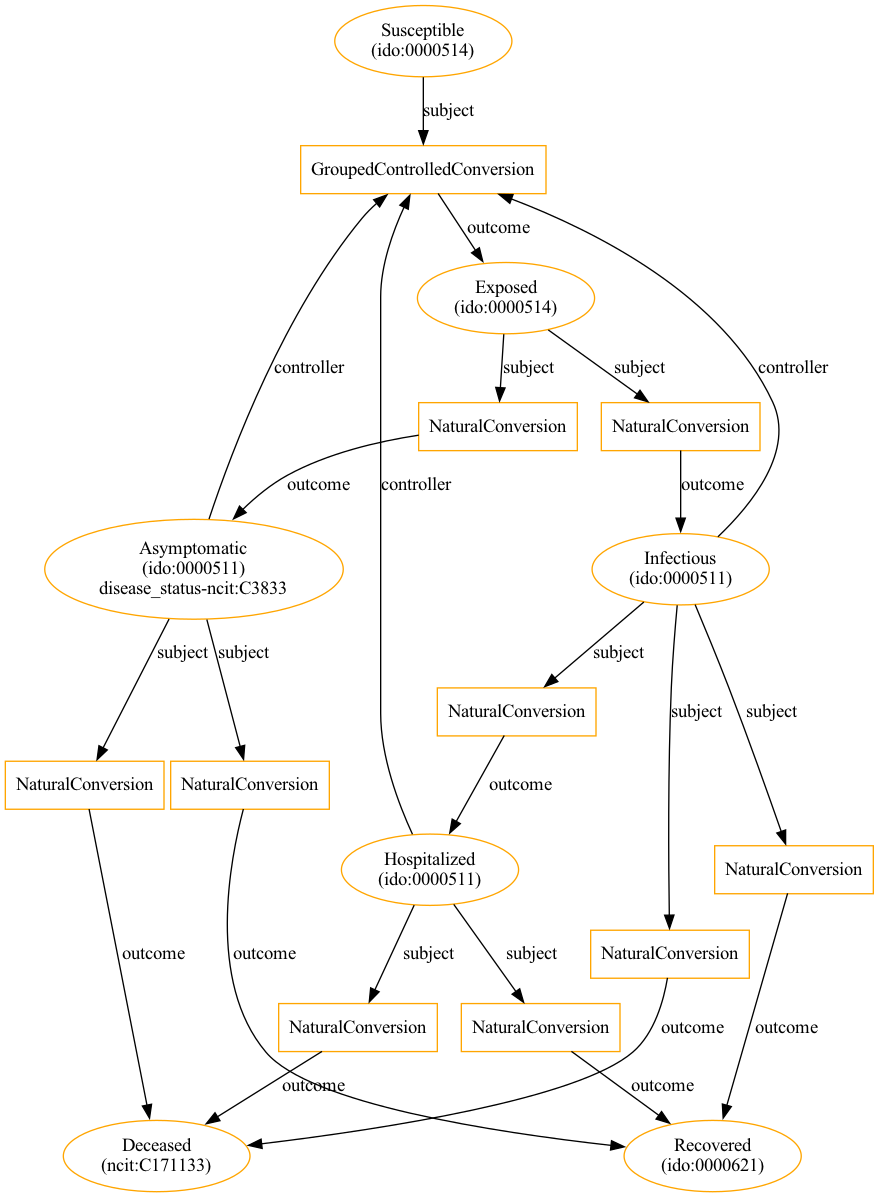

In [7]:
model_960.draw_graph("sc3_model_960.png")
Image(filename="sc3_model_960.png", width='50%')

## Human in the loop improvements
As can be seen in the output above, several concepts have vague identification and need to be better annotated in order to disambiguate them. The human in the loop intervention needed is "simulated" by the following mapping:

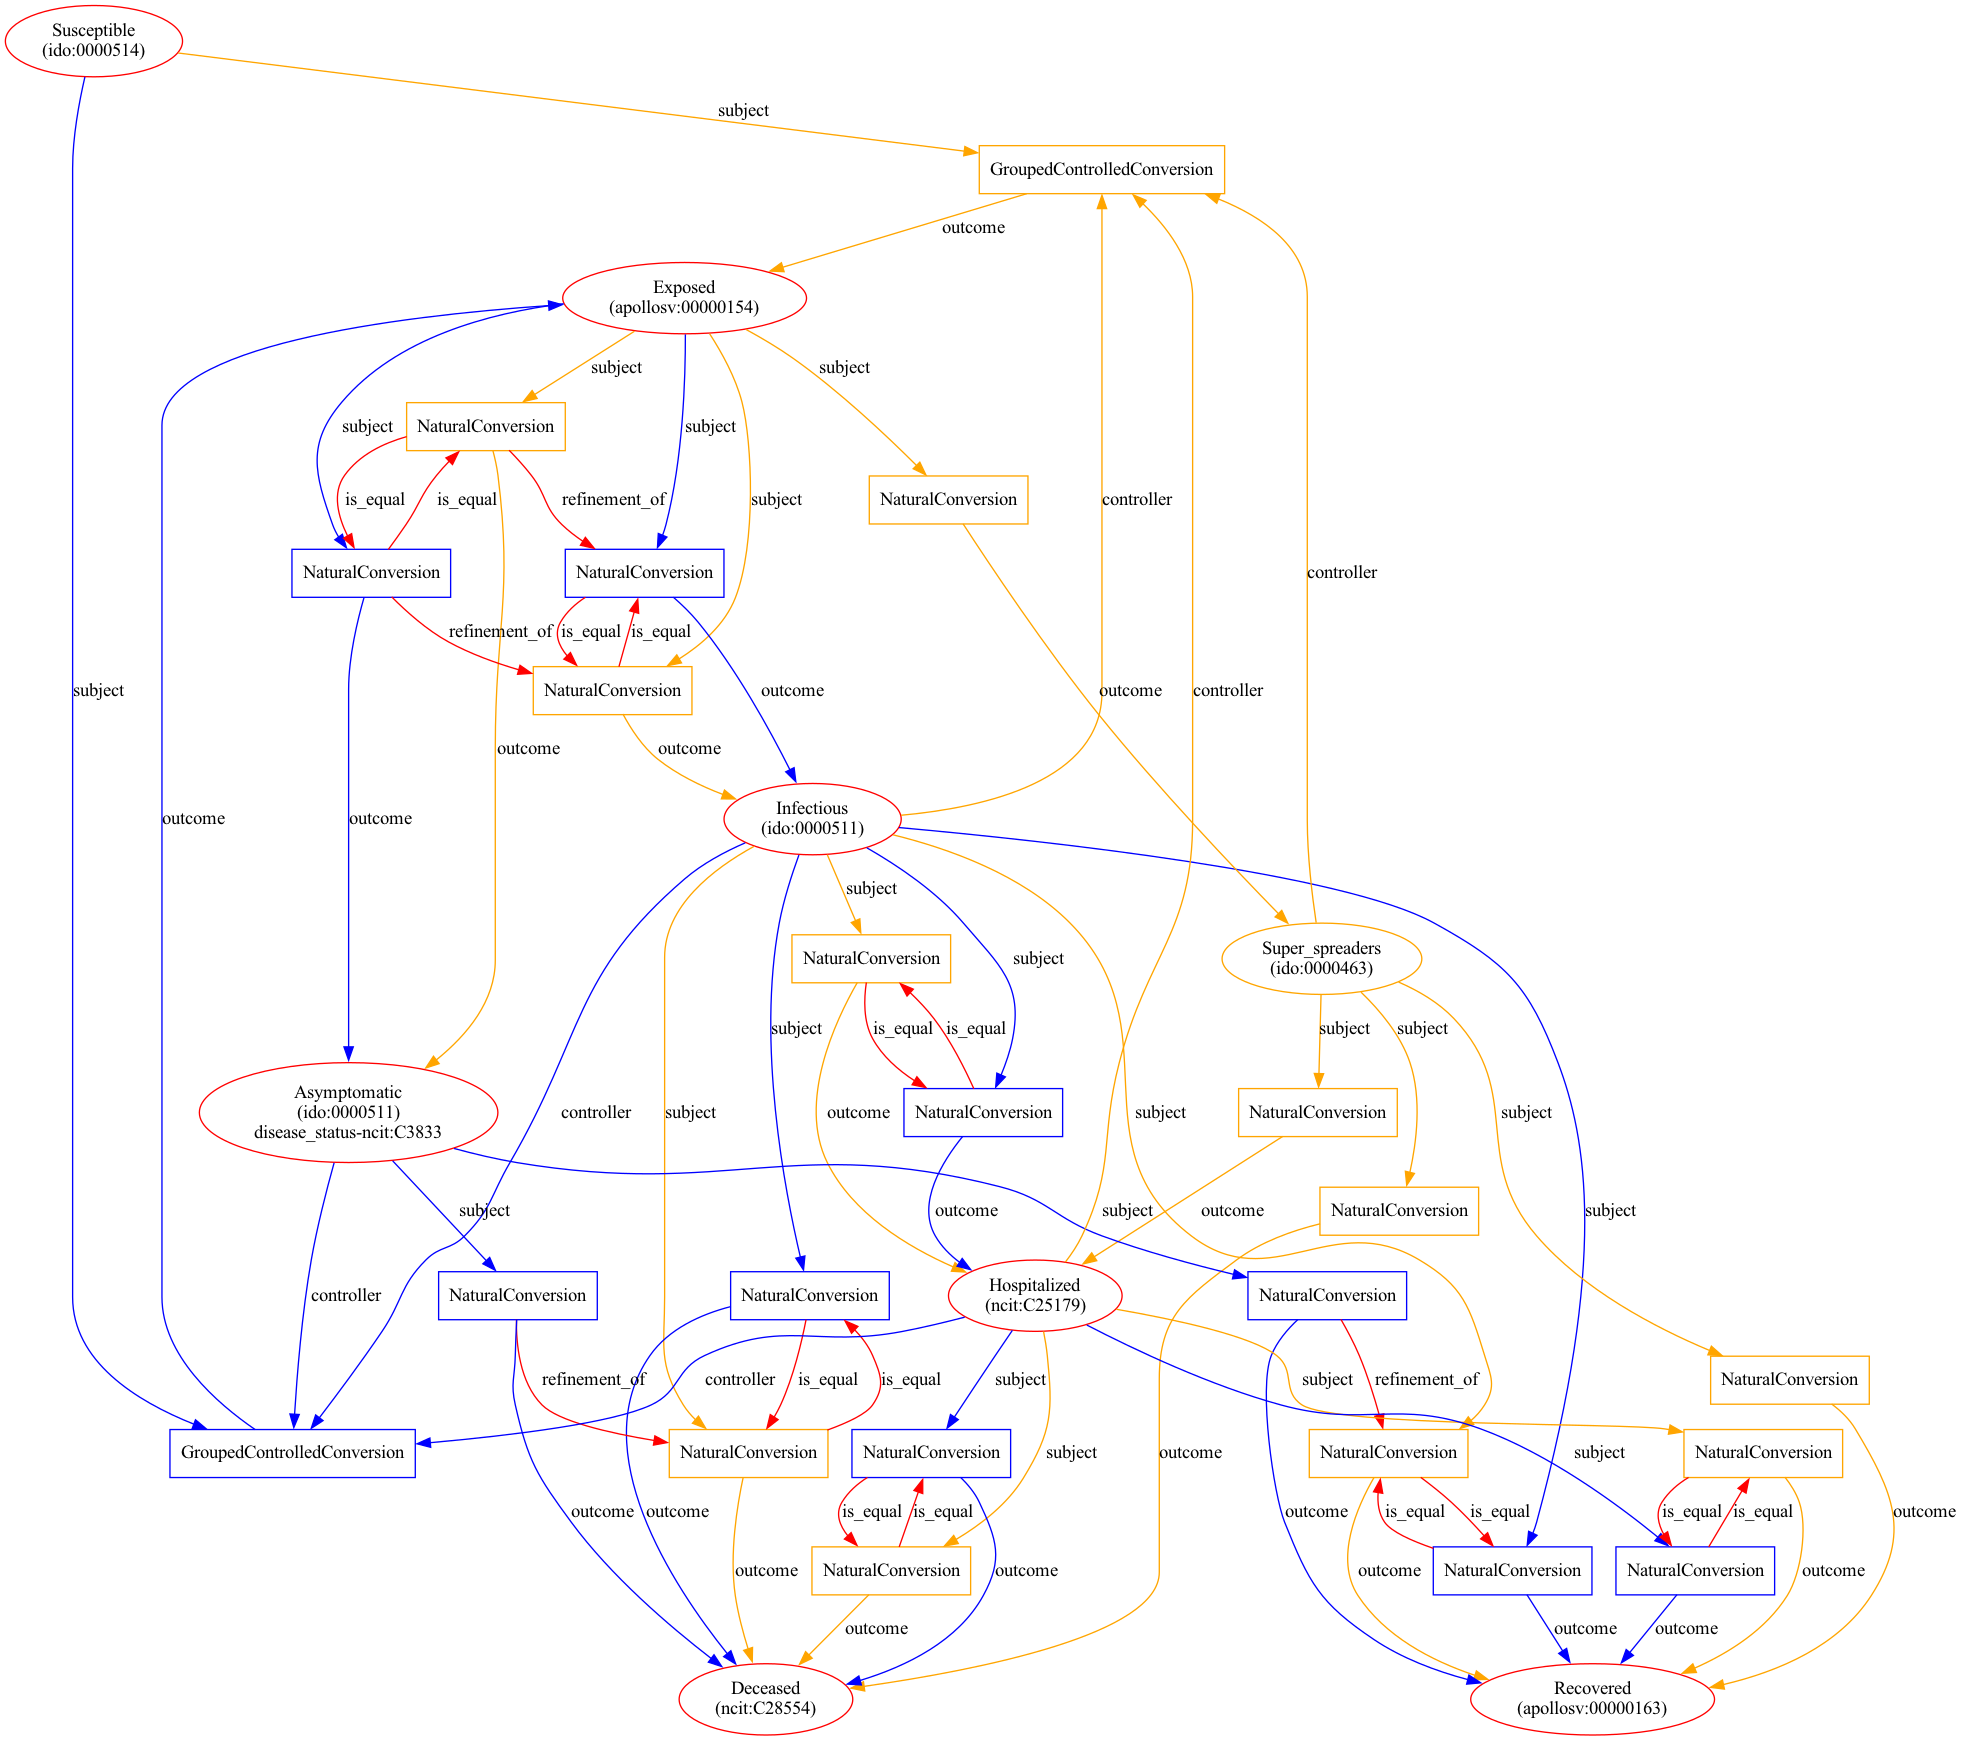

In [15]:
from mira.metamodel import Concept

# Identifiers seen here:
# ncit:C171133 (covid-19 infection) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C171133
# ncit:C28554 (death) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C28554
# ncit:C25179 (hospitalization) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C25179
# apollosv:00000163 (Recoverd Population) https://ontobee.org/ontology/APOLLO_SV?iri=http://purl.obolibrary.org/obo/APOLLO_SV_00000163
# ido:0000511 (infected population) https://www.ebi.ac.uk/ols/ontologies/ido/terms?obo_id=IDO:0000511
# ido:0000514 (susceptible population) https://www.ebi.ac.uk/ols/ontologies/ido/terms?obo_id=IDO:0000514

concept_mapping = {
    "958": {
        "Exposed": Concept(name="Exposed",
                           identifiers={"apollosv": "00000154"}),
        "Infectious": Concept(name="Infectious",
                              identifiers={"ido": "0000511", "apollosv": "00000163"}),
        "Fatalities": Concept(name="Fatalities",
                              identifiers={"ncit": "C28554"}),
        "Hospitalised": Concept(name="Hospitalised",
                                identifiers={"ncit": "C25179"}),
        "Recovered": Concept(name="Recovered",
                             identifiers={"apollosv": "00000163"}),
    },
    "960": {
        "Exposed": Concept(name="Exposed",
                           identifiers={"apollosv": "00000154"}),
        "Deceased": Concept(name="Deceased",
                            identifiers={"ncit": "C28554"}),
        "Infectious": Concept(name="Infectious",
                              identifiers={"ido": "0000511", "apollosv": "00000163"}),
        "Hospitalized": Concept(name="Hospitalized",
                                identifiers={"ncit": "C25179"}),
        "Recovered": Concept(name="Recovered",
                             identifiers={"apollosv": "00000163"}),
    }
}

# Map the concepts from previous
for template_958 in model_958.templates:
    for concept in template_958.get_concepts():
        if concept.name in concept_mapping["958"]:
            concept.identifiers = concept_mapping["958"][concept.name].identifiers

for template_960 in model_960.templates:
    for concept in template_960.get_concepts():
        if concept.name in concept_mapping["960"]:
            concept.identifiers = concept_mapping["960"][concept.name].identifiers

# Now do the comparison
tmd_corr = TemplateModelDelta(model_958, model_960, refinement_function=is_ontological_child_web)
tmd_corr.draw_graph("sc3_model_958_960_delta_corrected.png", args="-Grankdir=TB")
Image(filename="sc3_model_958_960_delta_corrected.png")

In [9]:
petri_958 = PetriNetModel(Model(model_958))
petri_960 = PetriNetModel(Model(model_960))
for mname, model in [("scenario3_biomd958.json", petri_958), ("scenario3_biomd960.json", petri_960)]:
    model.to_json_file(mname, indent=1)
# Also dump the mira model jsons
with open("scenario3_biomd958_mira.json", "w") as f:
    f.write(model_958.json(indent=1))
with open("scenario3_biomd960_mira.json", "w") as f:
    f.write(model_960.json(indent=1))

In [18]:
# Simplify rate laws and make new Petri net model
from mira.metamodel.ops import simplify_rate_laws, aggregate_parameters
for mname, model in [("scenario3_biomd958_rate_law_subs.json", model_958),
                     ("scenario3_biomd960_rate_law_subs.json", model_960)]:
    model2 = aggregate_parameters(simplify_rate_laws(model))
    pm = PetriNetModel(Model(model2))
    pm.to_json_file(mname, indent=1)

## Add vaccination
We now need to add vaccination to the two models

In [9]:
import sympy
from mira.examples.concepts import vaccinated
from mira.metamodel import NaturalConversion

# Get the susceptible Concepts from each of the models
susceptible_958 = None
for template in model_958.templates:
    if template.name == "GroupedControlledConversion":
        susceptible_958 = template.subject
        break
assert susceptible_958 is not None

susceptible_960 = None
for template in model_960.templates:
    if template.name == "GroupedControlledConversion":
        susceptible_960 = template.subject
        break
assert susceptible_960 is not None

# todo: add vaccination to the models
vaccination_rate = sympy.parse_expr("")
vaccination_conversion_958 = NaturalConversion(subject=susceptible_958, outcome=vaccinated, )
vaccination_conversion_960 = NaturalConversion(subject=susceptible_960, outcome=vaccinated, )

AttributeError: 'GroupedControlledConversion' object has no attribute 'name'

## Add reinfection
We're asked to add reinfection to the model. This is done by adding a new template to the model. The template is a `NaturalConversion` from `recovered` to `susceptible` or `recovered` straight to `infected`.